In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D,Conv3D,MaxPooling2D,Flatten,Dense,Dropout,GlobalAveragePooling2D,BatchNormalization,Activation
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm import tqdm

In [0]:
def load_imgs_and_keypoints(path):
    
    imgs = os.listdir(path+'images')
    imgs.sort()
    temp = []
    flag=-1
    
    for i in tqdm(imgs):
        i = Image.open(path+'images/' +i)
        i = i.resize((100,100))
        i=np.array(i)
        if(len(i.shape)<=2):
            flag=flag+1
            continue
        
        
        temp.append(i)
        flag=flag+1
        
    img = np.array(temp)
    ds = pd.read_csv(path + 'gt.csv')
    points = ds.values
    points = points[:,1:]
    points2=[]
    flag=0
    
    for i in tqdm(imgs):
        i = Image.open(path+'images/' +i)
        i = np.array(i)
        if(len(i.shape)==3):
            points[flag] = points[flag]/i.shape[0]
            points[flag] = points[flag]*100 
            points2.append(points[flag])
              
        flag = flag + 1
    
    points2 = np.array(points2)
    return img,points2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = 'drive/My Drive/facial-keypoints/data/'
images,points = load_imgs_and_keypoints(path)
print(images.shape)
print(points.shape)

100%|██████████| 6000/6000 [00:37<00:00, 160.84it/s]

(5955, 100, 100, 3)
(5955, 28)


In [0]:
def visualize_points(img,points):
  
    fig = plt.imshow(img)
    for i in range(0,27,2):
        x=points[i]
        y=points[i+1]    
        ax=plt.gca()
        rv = ax.add_patch(Circle((x,y),2))

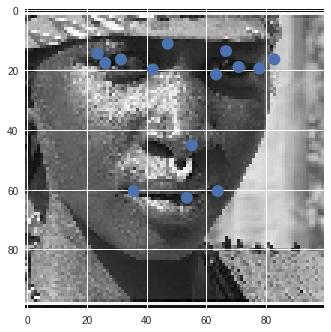

In [0]:
visualize_points(images[500],points[500])

In [0]:
imgs_train, imgs_val, points_train, points_val = train_test_split(images, points, test_size=0.1)

In [0]:
model = Sequential()
model.add(BatchNormalization(input_shape=(100, 100, 3)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dense(60, activation="relu"))
model.add(Dense(28))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 100, 100, 3)       12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 24)        1824      
_________________________________________________________________
activation_56 (Activation)   (None, 96, 96, 24)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 24)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 48, 48, 24)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 55296)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 300)               16589100  
__________

In [0]:
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
history2 = model.fit(imgs_train,points_train,batch_size = 30,epochs=250,validation_data=[imgs_val,points_val])

Train on 5359 samples, validate on 596 samples
Epoch 1/250
5359/5359 [==============================] - 9s 2ms/step - loss: 516.1762 - acc: 0.4124 - val_loss: 150.4825 - val_acc: 0.6309
Epoch 2/250
5359/5359 [==============================] - 7s 1ms/step - loss: 116.1433 - acc: 0.6800 - val_loss: 99.8606 - val_acc: 0.8440
Epoch 3/250
5359/5359 [==============================] - 7s 1ms/step - loss: 84.5032 - acc: 0.7188 - val_loss: 58.7035 - val_acc: 0.8070
Epoch 4/250
5359/5359 [==============================] - 7s 1ms/step - loss: 66.0993 - acc: 0.7785 - val_loss: 85.1263 - val_acc: 0.7685
Epoch 5/250
5359/5359 [==============================] - 7s 1ms/step - loss: 53.3613 - acc: 0.7985 - val_loss: 73.7057 - val_acc: 0.8674
Epoch 6/250
5359/5359 [==============================] - 7s 1ms/step - loss: 45.8014 - acc: 0.8095 - val_loss: 34.8589 - val_acc: 0.8725
Epoch 7/250
5359/5359 [==============================] - 7s 1ms/step - loss: 40.6080 - acc: 0.8138 - val_loss: 34.4179 - val_acc

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.jpg to test.jpg


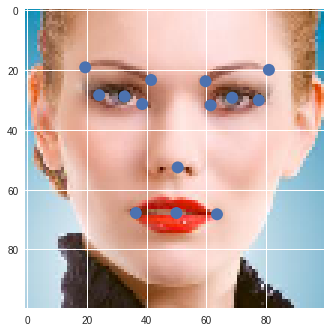

In [0]:
test_image = imgs_val[9]
p = points_val[9]
visualize_points(test_image,p)


In [0]:
prediction = model.predict(np.array([test_image]))
print(prediction)

[[17.404612 20.613754 40.318977 20.86867  57.394165 21.5876   80.06002
  21.237967 22.72566  29.138496 31.275867 28.81017  38.456524 29.796759
  60.02296  30.838957 67.833275 29.5089   75.6868   30.174658 49.804325
  50.838062 36.04529  68.43789  49.935707 68.92314  62.15626  68.50285 ]]


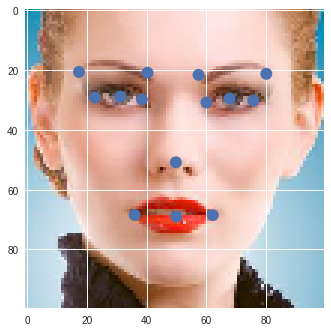

In [0]:
visualize_points(test_image,prediction[0])

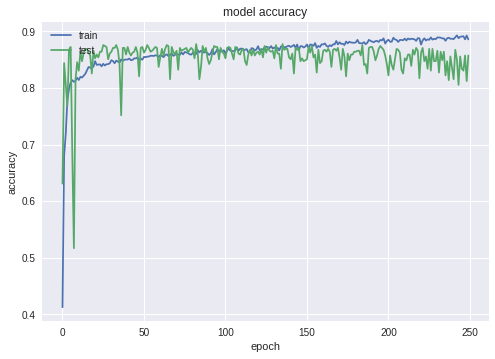

In [0]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('facial_keypoint_model2.h5')

In [0]:
from google.colab import files
files.download('facial_keypoint_model2.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 48820, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

sample_data
